# Creating fake neutrino data
First I just load the distribution I made online from that plot of energy vs. neutrino counts. Most of the start of this is the code you uploaded to the github. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

astro_filename = "./data/astrophysical.csv"
atmos_filename = "./data/atmosphere.csv"

astro_data = np.loadtxt(astro_filename, delimiter=",")
atmos_data = np.loadtxt(atmos_filename, delimiter=",")

Create new energy of the size of the dataset that I want, then create functions for the atmospheric and astro neutrinos. Then plot!

(0.0, 5.0)

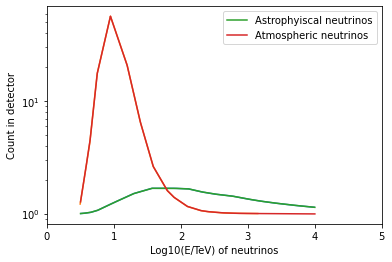

In [3]:
new_energy = np.linspace(0.5, 4, 100000)
f_astro = scipy.interpolate.interp1d(astro_data[:, 0], astro_data[:, 1], bounds_error=False, fill_value="extrapolate")
f_atmos = scipy.interpolate.interp1d(atmos_data[:, 0], atmos_data[:, 1], bounds_error=False, fill_value="extrapolate")

astro_flux = np.power(10,f_astro(new_energy))
atmos_flux = np.power(10,f_atmos(new_energy))

plt.semilogy(astro_data[:, 0], np.power(10,astro_data[:, 1]))
plt.semilogy(atmos_data[:, 0], np.power(10,atmos_data[:, 1]))
plt.semilogy(new_energy, astro_flux,label='Astrophyiscal neutrinos')
plt.semilogy(new_energy, atmos_flux,label='Atmospheric neutrinos')
plt.legend()
plt.xlabel('Log10(E/TeV) of neutrinos')
plt.ylabel('Count in detector')
plt.xlim(0, 5)

(array([16547., 57781., 13174.,  3016.,  1845.,  1550.,  1457.,  1551.,
         1520.,  1559.]),
 array([0.50021 , 0.850154, 1.200098, 1.550042, 1.899986, 2.24993 ,
        2.599874, 2.949818, 3.299762, 3.649706, 3.99965 ]),
 <BarContainer object of 10 artists>)

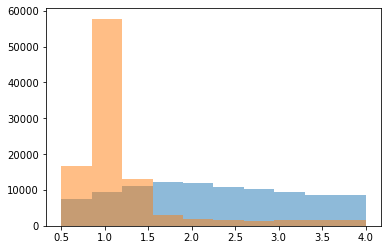

In [4]:
plt.hist(np.random.choice(new_energy, p = astro_flux / np.sum(astro_flux), size=100000), alpha=0.5)
plt.hist(np.random.choice(new_energy, p = atmos_flux / np.sum(atmos_flux), size=100000), alpha=0.5)

Here we create the background energies and the signal energies by using the probability that a given energy is an atmospheric or astrophysical neutrino. Then we create an boolean of length of the dataset and calculate the probability that a given energy is an atmos or astro neutrino. 

In [5]:

mc_background_energies = np.random.choice(new_energy, p = atmos_flux / np.sum(atmos_flux), size=100000)
mc_signal_energies = np.random.choice(new_energy, p = astro_flux / np.sum(astro_flux), size=100000)

mc_energies = np.random.choice(new_energy, p = (atmos_flux + astro_flux) / np.sum(atmos_flux + astro_flux), size=100000)

mc_signal = np.zeros(len(mc_energies), dtype=bool)
for i, eng_ in enumerate(mc_energies):
    prob_astro = f_astro(eng_) 
    prob_atmos = f_atmos(eng_)

    if(prob_astro < 0):
        prob_astro = 0
    if(prob_atmos < 0):
        prob_atmos = 0
    if(prob_astro == 0 and prob_atmos == 0):
        prob_astro = 0.5
        prob_atmos = 0.5
    else:
        norm = prob_astro + prob_atmos
        prob_astro /= norm
        prob_atmos /= norm
    
    mc_signal[i] = np.random.choice([False, True], p=[prob_atmos, prob_astro])
    
    


Next this is just a plot of the data that was calculated using probabilities--lines up with the plots of the raw data above. 

(array([7.4570e+03, 3.8341e+04, 2.1136e+04, 5.1820e+03, 1.8950e+03,
        8.5800e+02, 3.5500e+02, 1.4600e+02, 5.9000e+01, 1.4000e+01]),
 array([0.500035  , 0.77426274, 1.04849048, 1.32271823, 1.59694597,
        1.87117371, 2.14540145, 2.4196292 , 2.69385694, 2.96808468,
        3.24231242]),
 <BarContainer object of 10 artists>)

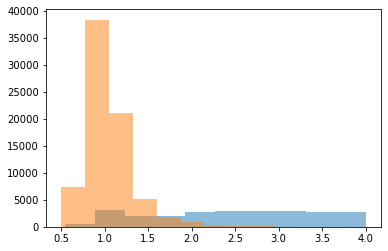

In [6]:
plt.hist(mc_energies[mc_signal], label="Signal", alpha=0.5)
plt.hist(mc_energies[np.logical_not(mc_signal)], label="Background", alpha=0.5)

Create a distribution of the background data that is uniform. Find the number of signal points v. background points

In [7]:
n_signal = sum(mc_signal)
n_background = len(mc_signal) - n_signal
background_ra = np.random.uniform(0, 360, size=n_background)
background_dec = np.random.uniform(-87, 87, size=n_background)

 Set size to the number of points to place near fake 4LAC sources. Create uniform data of the signal. Then set 'hello' to be 'size' number random indices of the data set. Delete those values from the dataset. Load up the coordinates of the 10 random sources from the fake 4lac set to use. Then, in this example, for each source, create a distribution of 5 points around the source, and add those points to the dataset. Repeat for each source. 

In [8]:
size=20
signal_ra = np.random.uniform(0,360,size=n_signal)
signal_dec = np.random.uniform(-87,87, size=n_signal)

hello = np.random.randint(len(signal_ra),size=size)

signal_ra = np.delete(signal_ra,hello,None)
signal_dec = np.delete(signal_dec,hello,None)


specific_coords = np.load("./processed_data/specific_coords.npz",
                       allow_pickle=True)

ra = np.array(specific_coords["specific_ra"])
dec = np.array(specific_coords["specific_dec"])
specific_ra = np.zeros(size)
specific_dec = np.zeros(size)


for i in range(10):
    specific_ra = np.random.normal(ra[i], 10, size=2)
    specific_dec = np.random.normal(dec[i],10,size=2)
    signal_ra = np.concatenate((signal_ra,specific_ra),axis=0)
    signal_dec = np.concatenate((signal_dec,specific_dec),axis=0)


Set background and signal energy based on probabilities. Join the background and the signal data points into one big set to mimic the data given by Icecube. Convert energy from the log scale. Load the IceCube data, and distribute the fake data_sigmas the same as IceCubes. Save!

In [9]:
background_energy = mc_energies[np.logical_not(mc_signal)]
signal_energy = mc_energies[mc_signal]

data_ra=np.concatenate((signal_ra,background_ra),axis=0)
data_dec=np.concatenate((signal_dec,background_dec),axis=0)
data_eng = np.concatenate((signal_energy,background_energy),axis=0)
data_eng = np.power(10,data_eng)



icecube_data = np.load("./processed_data/output_icecube_data.npz",
                       allow_pickle=True)
icecube_sigmas = np.array(icecube_data["data_sigmas"])
data_sigmas = np.random.choice(icecube_sigmas,100000)



np.savez("./processed_data/energy_cut_data.npz",
         data_sigmas = data_sigmas,
         data_ra= data_ra,
         data_dec=data_dec,
         data_eng = data_eng) 